In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.io as io

plt.rc("font", family=["Helvetica", "Arial"]) #skifter skrifttype
plt.rc("axes", labelsize=18)   #skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=16, direction="out")  #skriftstørrelse af ticks og viser ticks øverst
plt.rc("ytick", labelsize=16, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=16)

In [31]:
entries_list_sT = os.listdir(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/Luft til glas/s/Datafiler/transmitteret")
entries_list_sR = os.listdir(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/Luft til glas/s/Datafiler/reflekteret")

t1_90 = 90*np.pi/180

def func(x, a):
    return a

d = io.loadmat(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/baggrund måling.mat")
d_offset = d.get("A")
d_offset = np.reshape(d_offset, (len(d_offset)))

t = np.linspace(0, 50, len(d_offset))
mean_Voff, pcovoff = curve_fit(func, t, d_offset, absolute_sigma=True)
usOff = np.sqrt(np.diag(pcovoff))

d = io.loadmat(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/Luft til glas/s - 0 grader med krystal.mat")
d90 = d.get("A")
d90 = np.reshape(d90, (len(d90)))


t = np.linspace(0, 50, len(d90))
mean_V90, pcov90 = curve_fit(func, t, d90, absolute_sigma=True)
us90 = np.sqrt(np.diag(pcov90))
mean_V90 = mean_V90 - mean_Voff



In [32]:
def get_ts_Vs(t, entries):
    if t == "T":
        rempart = "t("
        file_dest = "transmitteret"
    else:
        rempart = "r("
        file_dest = "reflekteret"
        
    ts = np.zeros((len(entries), 2))
    Vs = np.zeros((len(entries),2))
    for i, file in enumerate(entries):
        name = file.replace(rempart, "")
        name = name.replace(".mat", "")
        name = name.replace(")", "")
        indx = name.find(",")
        ts12 = float(name[0:indx])*np.pi/180, float(name[indx + 1:len(name)])*np.pi/180
        ts[i] = ts12
        dat = io.loadmat(f"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/luft til glas/s/Datafiler/{file_dest}/{file}")
        V = dat.get("A")
        V = np.reshape(V, (len(V)))
        xs = np.linspace(0, 50, len(V))
        fitted, pcov = curve_fit(func, xs, V, absolute_sigma=True)
        perr1 = np.sqrt(np.diag(pcov))
        Vs[i][0] = fitted - mean_Voff
        Vs[i][1] = perr1
        
    return Vs, ts

In [33]:
mean_VsT, ts_trans = get_ts_Vs("T", entries_list_sT)
mean_VsR, ts_ref = get_ts_Vs("R", entries_list_sR)

In [34]:
Ts = mean_VsT/mean_V90
Rs = mean_VsR/mean_V90
print(Rs)

[[ 0.02757234  0.00207829]
 [ 1.0264399   0.00207829]
 [ 0.05906457  0.00207829]
 [-0.01647292  0.00207829]
 [ 0.06871762  0.00207829]
 [ 0.07131888  0.00207829]
 [ 0.09601314  0.00207829]
 [ 0.1109421   0.00207829]
 [ 0.11305421  0.00207829]
 [ 0.112712    0.00207829]
 [ 0.11738494  0.00207829]
 [ 0.13777711  0.00207829]
 [ 0.15495217  0.00207829]
 [ 0.15802074  0.00207829]
 [ 0.19905382  0.00207829]
 [ 0.20193998  0.00207829]
 [ 0.24020342  0.00207829]
 [ 0.31216463  0.00207829]
 [ 0.43361126  0.00207829]
 [ 0.57118315  0.00207829]
 [ 0.74618709  0.00207829]]


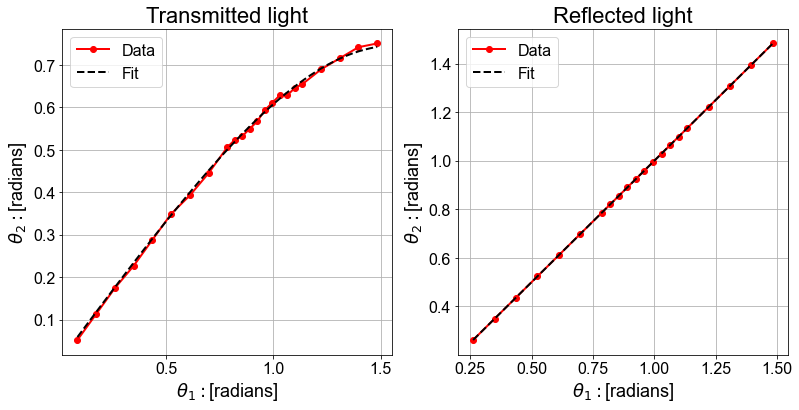

In [35]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title("Reflected light")
axs[0].set_title("Transmitted light")

def snell(theta, n):
    theta_ag = np.arcsin(n*np.sin(theta))
    return theta_ag

theta1T = np.zeros(len(ts_trans))
theta2T = np.zeros(len(ts_trans))

theta1R = np.zeros(len(ts_ref))
theta2R = np.zeros(len(ts_ref))

i = 0
for t1, t2 in ts_trans:
    theta1T[i] = t1
    theta2T[i] = (t1 - t2)
    i = i + 1
    
i = 0
for t1, t2 in ts_ref:
    theta1R[i] = t1
    theta2R[i] = t1
    i = i + 1

axs[0].plot(np.sort(theta1T), np.sort(theta2T), 'o-', c='r', lw=2, label="Data")
axs[1].plot(np.sort(theta1R), np.sort(theta2R), 'o-', c='r', lw=2, label="Data")

nT, pcovT = curve_fit(snell, theta1T, theta2T)
nR, pcovR = curve_fit(snell, theta1R, theta2R, absolute_sigma=True)

theta_T = np.linspace(min(theta1T), max(theta1T))
theta_R = np.linspace(min(theta1R), max(theta1R))

axs[0].plot(theta_T, snell(theta_T, nT), c='k', ls="--", label="Fit", lw=2)
axs[1].plot(theta_R, snell(theta_R, nR), c='k', ls="--", label="Fit", lw=2)

for ax in axs:
    ax.grid()
    ax.set_xlabel(r"$\theta_1: $[radians]")
    ax.set_ylabel(r"$\theta_2: $[radians]")
    ax.legend()

In [36]:
print(1/nT, np.sqrt(np.diag(pcovT)))
uncer = 0.5 # DEGREES
sigma_radian = np.pi/180 * uncer
print(sigma_radian)


[1.47374237] [0.00135668]
0.008726646259971648


Text(0, 0.5, '$R_s$')

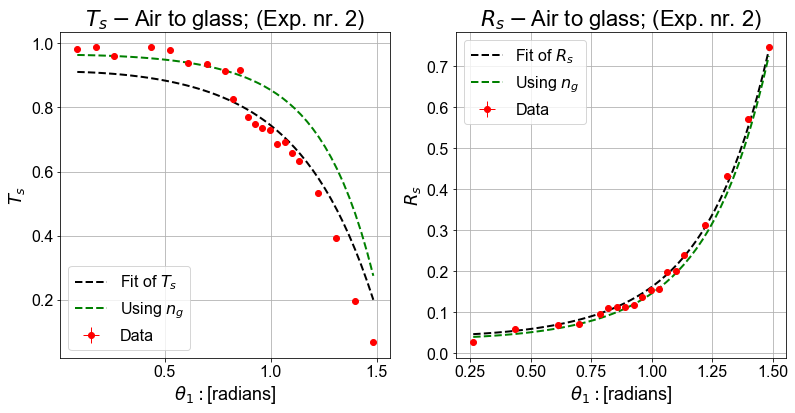

In [49]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title(r"$R_s-$Air to glass; (Exp. nr. 2)")
axs[0].set_title(r"$T_s-$Air to glass; (Exp. nr. 2)")


def Rkoef(theta_1, n_komb): #Gælder kun for S polariseret lys
    theta_2 = np.arcsin(n_komb*np.sin(theta_1)) #Indsæt kombination af brydningsindekser, så det passer med f.eks. ns = n_a/n_g, eller omvendt
    R_s = np.sin(theta_1 - theta_2)**2/(np.sin(theta_1 + theta_2)**2)
    return R_s

def Tkoef(theta_1, n_komb): #Gælder kun for S polariseret lys
    theta_2 = np.arcsin(n_komb*np.sin(theta_1))
    T_s = np.sin(2*theta_1)*np.sin(2*theta_2)/(np.sin(theta_1 + theta_2)**2)
    return T_s


T_uc = []
R_uc = []
Tl = [] #Fjerner vinkler og punkter, hvor T,R ikke ligger mellem intervallet [0,1]
Rl = []
theta_newT = []
theta_newR = []

for i, a in enumerate(Ts):
    if a[0] > 0.05 and a[0] < 1: #Fjerner dem her
        Tl.append(a[0])
        theta_newT.append(theta1T[i])
        T_uc.append(0.00207829)

for i, a in enumerate(Rs):
    if a[0] > 0 and a[0] < 1:
        Rl.append(a[0])
        theta_newR.append(theta1R[i])
        R_uc.append(0.00207829)
        
nTT, pcovnT = curve_fit(Tkoef, theta_newT, Tl, absolute_sigma=True, bounds=(0.2,1))
nRR, pcovnR = curve_fit(Rkoef, theta_newR, Rl, absolute_sigma=True, bounds=(0.2,1))

theta_T = np.linspace(min(theta_newT), max(theta_newT))
theta_R = np.linspace(min(theta_newR), max(theta_newR))

axs[0].errorbar(theta_newT, Tl, xerr=sigma_radian, yerr=T_uc, lw=1, label="Data", c='r', fmt='o')
axs[1].errorbar(theta_newR, Rl, xerr=sigma_radian, yerr=R_uc, lw=1, label="Data", c='r', fmt='o')

axs[0].plot(theta_T, Tkoef(theta_T, nTT), ls="--", c="k", lw=2, label=r"Fit of $T_s$")
axs[1].plot(theta_R, Rkoef(theta_R, nRR), ls="--", c="k", lw=2, label=r"Fit of $R_s$")

axs[0].plot(theta_T, Tkoef(theta_T, 1/1.47374237), ls="--", c="g", lw=2, label=r"Using $n_g$")
axs[1].plot(theta_R, Rkoef(theta_R, nT), ls="--", c="g", lw=2, label=r"Using $n_g$")


for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel(r"$\theta_1: $[radians]")
axs[0].set_ylabel(r"$T_s$")
axs[1].set_ylabel(r"$R_s$")

In [38]:
print(1/nT, np.sqrt(np.diag(pcovT)))
print(1/nTT, np.sqrt(np.diag(pcovnT)))
print(1/nRR, np.sqrt(np.diag(pcovnR)))

[1.47374237] [0.00135668]
[1.85144352] [0.27931806]
[1.52287541] [0.32971624]


# P-værdi og Chi^2 min værdi - for snells lov fit

In [39]:
yerr = np.zeros(len(theta1T))
for i in range(len(yerr)):
    yerr[i] = 0.5*np.pi/180 #Fejlen på vores vinkler

v = len(theta1T) - 1

chmin = np.sum(((theta2T-snell(theta1T, nT))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 


In [40]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

12.61916848035314  <  10.131881322500117  <  31.38083151964686
0.99


# P-værdi og Chi^2 min værdi for T og R fit

In [41]:
yerr = np.zeros(len(Tl))
for i in range(len(yerr)):
    yerr[i] = 0.002943/np.sqrt(len(Tl))

v = len(Tl) - 1
print(len(Tl), len(theta_newT), len(yerr))
chmin = np.sum(((np.array([theta_newT])-Tkoef(np.array([theta_newT]), nTT))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

22 22 22


In [42]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

11.83484861008832  <  16810548.02721791  <  30.165151389911678
0.0


In [43]:
yerr = np.zeros(len(Rl))
for i in range(len(yerr)):
    yerr[i] = 0.002943/np.sqrt(len(Rl)) #Fejlen på vores vinkler

v = len(Rl) - 1
chmin = np.sum(((np.array([theta_newR])-Tkoef(np.array([theta_newR]), nRR))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

In [44]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

9.51471862576143  <  9809117.09470433  <  26.485281374238568
0.0
